 # 13. Utility-Scale Experiment II
Yukio Kawashima (July 12, 2024)<br>
© IBM Corp. 2024

*Approximate QPU time to run this experiment is 2 m 30 s.*

Note that this notebook used texts, illustration, and codes in [a tutorial notebook](https://github.com/qiskit-community/qiskit-algorithms/blob/main/docs/tutorials/13_trotterQRTE.ipynb) for Qiskit Algorithms.

This notebook follows the methods and techniques of lesson 7. Our goal is to numerically solve the time-dependent Schrödinger equation. As discussed in lesson 7, Trotterization consists in the successive application of a quantum gate or gates, chosen to approximate the time evolution of a system for a time slice. We repeat that discussion here for convenience. Feel free to skip to the code cells below if you have recently reviewed lesson 7.

Following from the Schrödinger equation, the time evolution of a system initially in the state $\vert\psi(0)\rangle$ takes the form:

$$
\vert \psi(t) \rangle = e^{-i H t} \vert \psi(0) \rangle \text{,}
$$

where $H$ is the time-independent Hamiltonian governing the system. We consider a Hamiltonian that can be written as a weighted sum of Pauli terms $H=\sum_j a_j P_j$, with $P_j$ representing a tensor product of Pauli terms acting on $n$ qubits. In particular, these Pauli terms might commute with one another, or they might not. Given a state at time $t=0$, how do we obtain the system's state at a later time $|\psi(t)\rangle$ using a quantum computer? The exponential of an operator can be most easily understood through its Taylor series:

$$
e^{-i H t} = 1-iHt-\frac{1}{2}H^2t^2+...
$$

Some very basic exponentials, like $e^{iZ}$ can be implemented easily on quantum computers using a compact set of quantum gates. Most Hamiltonians of interest will not have just a single term, but will instead have many terms. Note what happens if $H = H_1+H_2$:

$$
e^{-i H t} = 1-i(H_1+H_2)t-\frac{1}{2}(H_1+H_2)^2t^2+...
$$

When $H_1$ and $H_2$ commute, we have the familiar case (which is also true for numbers, and variables $a$ and $b$ below):

$$
e^{-i (a+b) t} = e^{-i a t}e^{-i b t}
$$

But when operators do not commute, terms cannot be rearranged in the Taylor series to simplify in this way. Thus, expressing complicated Hamiltonians in quantum gates is a challenge.

One solution is to consider very small time $t$, such that the first-order term in the Taylor expansion dominates. Under that assumption:

$$
e^{-i (H_1+H_2) t} \approx 1-i(H_1+H_2)t \approx (1-i H_1 t)(1-i H_2 t) \approx e^{-i H_1 t}e^{-i H_2 t}
$$

Of course, we may need to evolve our state for a longer time. That is accomplished by using many such small steps in time. This process is called Trotterization:

$$
\vert \psi(t) \rangle \approx \left(\prod_j e^{-i a_j P_j t/r} \right)^r \vert\psi(0) \rangle \text{,}
$$

Here $t/r$ is the time slice (evolution step) that we are choosing. As a result, a gate to be applied $r$ times is created. A smaller timestep leads to a more accurate approximation. However, this also leads to deeper circuits which, in practice, leads to more error accumulation (a non-negligible concern on near-term quantum devices). 

Today, we will study the time evolution of the [Ising model](https://en.wikipedia.org/wiki/Ising_model) on linear lattices of $N=2$ and $N=6$ sites. These lattices consist of an array of spins $\sigma_i$ that interact only with their nearest neighbors. These spins can have two orientations: $\uparrow$ and $\downarrow$, which correspond to a magnetization of $+1$ and $-1$ respectively.

$$
H = - J \sum_{i=0}^{N-2} Z_i Z_{i+1} - h \sum_{i=0}^{N-1} X_i  \text{,}
$$

where $J$ describes the interaction energy, and $h$ the magnitude of an external field (in the x-direction above, but we will modify this). Let us write this expression using Pauli matrices, and considering that the external field has an angle $\alpha$ with respect to the transversal direction,

$$
H = -J \sum_{i=0}^{N-2} Z_i Z_{i+1} -h \sum_{i=0}^{N-1} (\sin\alpha Z_i + \cos\alpha X_i) \text{.}
$$

This Hamiltonian is useful in that it allows us to easily study the effects of an external field. In the computational basis, the system will be encoded as follows:

| Quantum state            | Spin representation                        |
|:------------------------:|:------------------------------------------:|
| $\lvert 0 0 0 0 \rangle$ | $\uparrow\uparrow\uparrow\uparrow$         |
| $\lvert 1 0 0 0 \rangle$ | $\downarrow\uparrow\uparrow\uparrow$       |
| $\ldots$                 | $\ldots$                                   |
| $\lvert 1 1 1 1 \rangle$ | $\downarrow\downarrow\downarrow\downarrow$ |

We will start investigating the time evolution of such a quantum system. More specifically, we will visualize the time-evolution of certain properties of the system like magnetization.

In [1]:
# Check the version of Qiskit
import qiskit
qiskit.__version__

'1.3.0'

In [2]:
# Import the qiskit library
import math
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
from typing import Union, List
import warnings

warnings.filterwarnings("ignore")

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit.synthesis import (
    SuzukiTrotter, 
    MatrixExponential, 
    QDrift, 
    ProductFormula, 
    LieTrotter
)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator

## Code for defining the transverse-field Ising Hamiltonian
We here consider the 1-D transverse-field Ising model <br>

First, we will create a function that takes in the system parameters $N$, $J$, and $h$, and returns our Hamiltonian as a `SparsePauliOp`. A [SparsePauliOp](https://docs.quantum.ibm.com/api/qiskit/qiskit.quantum_info.SparsePauliOp) is a sparse representation of an operator in terms of weighted [Pauli](https://docs.quantum.ibm.com/api/qiskit/qiskit.quantum_info.Pauli) terms.

## Activity 1
Construct a function to build a transverse-field Ising Hamiltonian (see the equation above) with arguments of "the number of qubits", "J parameter", and "h parameter". Try this on your own using previous examples. Scroll down for the solution.

__Solution:__

In [4]:
def get_hamiltonian(nqubits, J, h):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, nqubits - 1)]
    X_tuples = [("X", [i], -h) for i in range(0, nqubits)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *X_tuples], num_qubits=nqubits)
    return hamiltonian.simplify()

# I. Solution using simulators
We will start investigating the time evolution of a quantum system, while keeping track of magnetization.
We here compare the results of the Statevector and Matrix Product State simulators.

### Define the Hamiltonian
The system that we now consider has a size of $N=20$.

In [5]:
n_qubits = 20
hamiltonian = get_hamiltonian(nqubits=n_qubits, J=1.0, h=-5.0)
hamiltonian

SparsePauliOp(['IIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIIIIIZZII', 'IIIIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIIIIZZIIII', 'IIIIIIIIIIIIIZZIIIII', 'IIIIIIIIIIIIZZIIIIII', 'IIIIIIIIIIIZZIIIIIII', 'IIIIIIIIIIZZIIIIIIII', 'IIIIIIIIIZZIIIIIIIII', 'IIIIIIIIZZIIIIIIIIII', 'IIIIIIIZZIIIIIIIIIII', 'IIIIIIZZIIIIIIIIIIII', 'IIIIIZZIIIIIIIIIIIII', 'IIIIZZIIIIIIIIIIIIII', 'IIIZZIIIIIIIIIIIIIII', 'IIZZIIIIIIIIIIIIIIII', 'IZZIIIIIIIIIIIIIIIII', 'ZZIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIX', 'IIIIIIIIIIIIIIIIIIXI', 'IIIIIIIIIIIIIIIIIXII', 'IIIIIIIIIIIIIIIIXIII', 'IIIIIIIIIIIIIIIXIIII', 'IIIIIIIIIIIIIIXIIIII', 'IIIIIIIIIIIIIXIIIIII', 'IIIIIIIIIIIIXIIIIIII', 'IIIIIIIIIIIXIIIIIIII', 'IIIIIIIIIIXIIIIIIIII', 'IIIIIIIIIXIIIIIIIIII', 'IIIIIIIIXIIIIIIIIIII', 'IIIIIIIXIIIIIIIIIIII', 'IIIIIIXIIIIIIIIIIIII', 'IIIIIXIIIIIIIIIIIIII', 'IIIIXIIIIIIIIIIIIIII', 'IIIXIIIIIIIIIIIIIIII', 'IIXIIIIIIIIIIIIIIIII', 'IXIIIIIIIIIIIIIIIIII', 'XIIIIIIIIIIIIIIIIIII'],
              coeffs=[-1.+0.j, -1.+0.j, -1.+0.j,

### Set the parameters of the time-evolution simulation
Here we will consider the Lie–Trotter (first order). <br>

In [6]:
num_timesteps = 20
evolution_time = 2.0
dt = evolution_time / num_timesteps
product_formula_lt = LieTrotter()

### Prepare the quantum circuit (Initial state)
Create an initial state. We will start from the ground state, which is a ferromagnetic state (all up or all down). Here, we use an example of all ups (which is all '0').

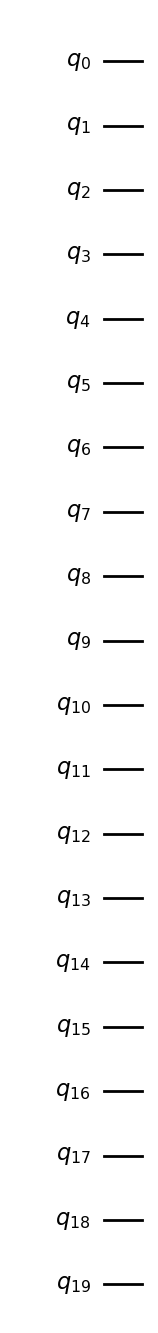

In [7]:
initial_circuit = QuantumCircuit(n_qubits)
initial_circuit.prepare_state('00000000000000000000')
# Change reps and see the difference when you decompose the circuit
initial_circuit.decompose(reps=1).draw("mpl")

### Prepare the quantum circuit 2 (Single circuit for time evolution)
We here construct a circuit for a single time step using Lie–Trotter.<br>
The Lie product formula (first order) is implemented in the [LieTrotter](https://docs.quantum.ibm.com/api/qiskit/qiskit.synthesis.LieTrotter) class. A first order formula consists of the approximation stated in the introduction, where the matrix exponential of a sum is approximated by a product of matrix exponentials:

$$
e^{H_1+H_2} \approx e^{H_1} e^{H_2}
$$
Let us count the operations for this circuit.<br>


Trotter step with Lie-Trotter
-----------------------------
Depth: 58
Gate count: 77
Nonlocal gate count: 38
Gate breakdown: CX: 38, U3: 20, U1: 19



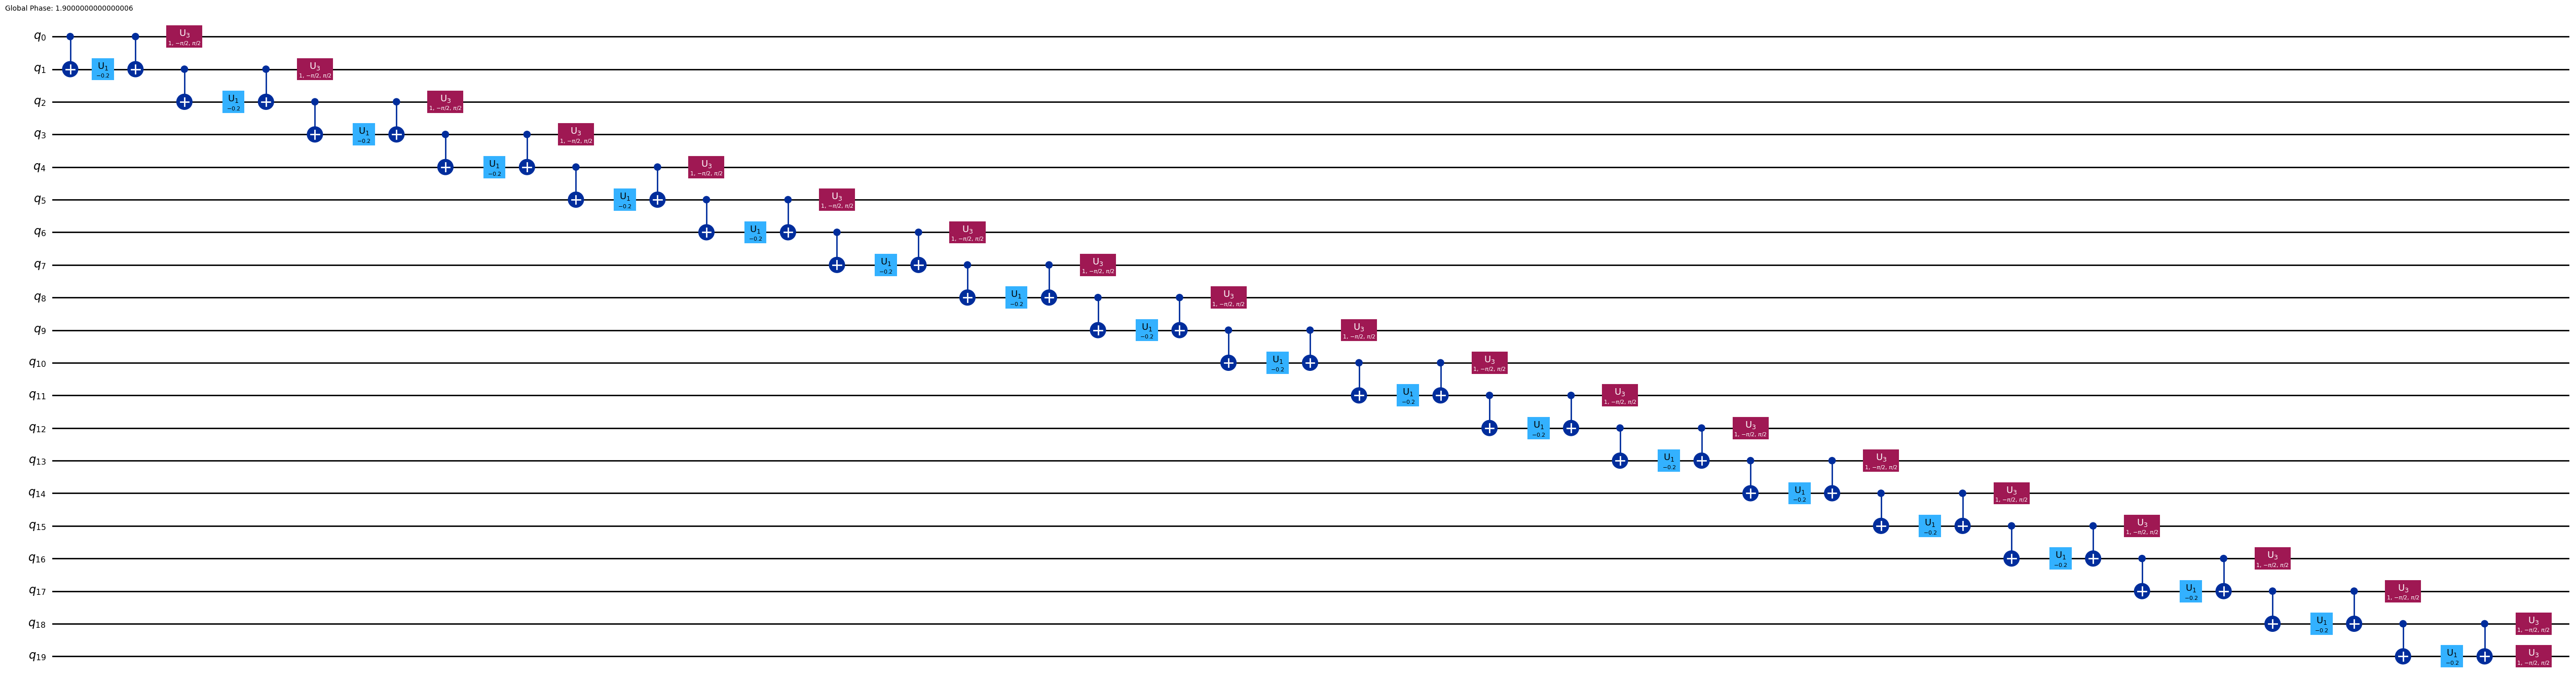

In [8]:
single_step_evolution_gates_lt = PauliEvolutionGate(
    hamiltonian, dt, synthesis=product_formula_lt
)
single_step_evolution_lt = QuantumCircuit(n_qubits)
single_step_evolution_lt.append(single_step_evolution_gates_lt, single_step_evolution_lt.qubits)

print(
    f"""
Trotter step with Lie-Trotter
-----------------------------
Depth: {single_step_evolution_lt.decompose(reps=3).depth()}
Gate count: {len(single_step_evolution_lt.decompose(reps=3))}
Nonlocal gate count: {single_step_evolution_lt.decompose(reps=3).num_nonlocal_gates()}
Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in single_step_evolution_lt.decompose(reps=3).count_ops().items()])}
"""
)
single_step_evolution_lt.decompose(reps=3).draw("mpl", fold=-1)

### Set the operators to be measured
Let us define a *magnetization operator* $\sum_i Z_i  / N$.

In [9]:
magnetization= SparsePauliOp.from_sparse_list(
    [("Z", [i], 1.0) for i in range(0, n_qubits)], num_qubits=n_qubits
) / n_qubits
print('magnetization : ', magnetization)

magnetization :  SparsePauliOp(['IIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIIIZIIIIII', 'IIIIIIIIIIIIZIIIIIII', 'IIIIIIIIIIIZIIIIIIII', 'IIIIIIIIIIZIIIIIIIII', 'IIIIIIIIIZIIIIIIIIII', 'IIIIIIIIZIIIIIIIIIII', 'IIIIIIIZIIIIIIIIIIII', 'IIIIIIZIIIIIIIIIIIII', 'IIIIIZIIIIIIIIIIIIII', 'IIIIZIIIIIIIIIIIIIII', 'IIIZIIIIIIIIIIIIIIII', 'IIZIIIIIIIIIIIIIIIII', 'IZIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIIIIIII'],
              coeffs=[0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j,
 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j,
 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j])


### Perform time-evolution simulation
We will monitor the magnetization (expectation value of the magnetization operator). We will use Statevector and MPS simulators and compare the results. <br>

In [10]:
# Step 1. Map the problem
# Initiate the circuit
evolved_state = QuantumCircuit(initial_circuit.num_qubits)
# Start from the initial spin configuration
evolved_state.append(initial_circuit, evolved_state.qubits)

# Define backend (simulator)
# MPS
backend_mps = AerSimulator(method='matrix_product_state')
# Statevector
backend_sv = AerSimulator(method='statevector')

# Set Runtime Estimator
# MPS
estimator_mps = Estimator(mode=backend_mps)
# Statevector
estimator_sv = Estimator(mode=backend_sv)

# Step 2. Optimize
# Set pass manager
# MPS
pm_mps = generate_preset_pass_manager(optimization_level=3, backend=backend_mps)
# Statevector
pm_sv = generate_preset_pass_manager(optimization_level=3, backend=backend_sv)

# Transpile initial circuit
# MPS
evolved_state_mps = pm_mps.run(evolved_state)
# Statevector
evolved_state_sv = pm_sv.run(evolved_state)

# Apply layout to the operator
# MPS
magnetization_mps = magnetization.apply_layout(evolved_state_mps.layout)
# Statevector
magnetization_sv = magnetization.apply_layout(evolved_state_sv.layout)

mag_mps_list = []
mag_sv_list = []

# Step 3. Run the circuit
# Estimate expectation values for t=0.0: MPS
job = estimator_mps.run([(evolved_state_mps, [magnetization_mps])])
# Get estimated expectation values: MPS
evs = job.result()[0].data.evs
# Collect data: MPS
mag_mps_list.append(evs[0])

# Estimate expectation values for t=0.0: Statevector
job = estimator_sv.run([(evolved_state_sv, [magnetization_sv])])
# Get estimated expectation values: Statevector
evs = job.result()[0].data.evs
# Collect data: Statevector
mag_sv_list.append(evs[0])

# Start time evolution
for n in range(num_timesteps):
    # Step 1. Map the problem
    # Expand the circuit to describe delta-t
    evolved_state.append(single_step_evolution_lt, evolved_state.qubits)
    # Step 2. Optimize
    # Transpile the circuit: MPS
    evolved_state_mps = pm_mps.run(evolved_state)
    # Apply the physical layout of the qubits to the operator: MPS
    magnetization_mps = magnetization.apply_layout(evolved_state_mps.layout)
    # Step 3. Run the circuit
    # Estimate expectation values at delta-t: MPS
    job = estimator_mps.run([(evolved_state_mps, [magnetization_mps])])
    # Get estimated expectation values: MPS
    evs = job.result()[0].data.evs
    # Collect data: MPS
    mag_mps_list.append(evs[0])

    # Step 2. Optimize
    # Transpile the circuit: Statevector
    evolved_state_sv = pm_sv.run(evolved_state)
    # Apply the physical layout of the qubits to the operator: Statevector
    magnetization_sv = magnetization.apply_layout(evolved_state_sv.layout)
    # Step 3. Run the circuit
    # Estimate expectation values at delta-t: Statevector
    job = estimator_sv.run([(evolved_state_sv, [magnetization_sv])])
    # Get estimated expectation values: Statevector
    evs = job.result()[0].data.evs
    # Collect data: Statevector
    mag_sv_list.append(evs[0])

# Transform the list of expectation values (at each time step) to arrays
mag_mps_array = np.array(mag_mps_list)
mag_sv_array = np.array(mag_sv_list)

### Plot the time evolution of the observables
We plot the expectation values we measured against time. Confirm that the results from statevector and matrix product space simulators agree.

Text(0.5, 0.98, 'Observable evolution')

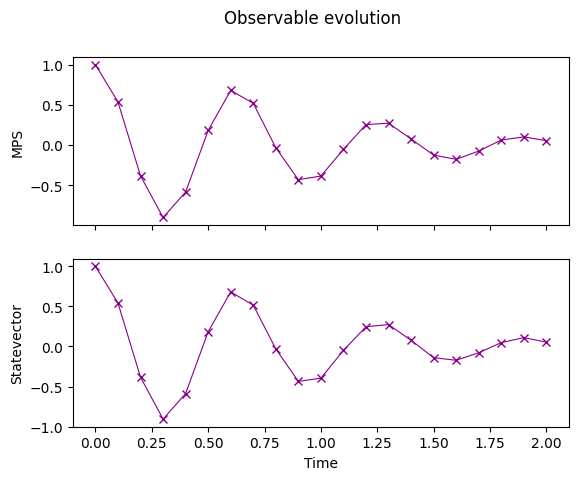

In [11]:
import matplotlib.pyplot as plt

# Step 4. Postprocessing
fig, axes = plt.subplots(2, sharex=True)
times = np.linspace(0, evolution_time, num_timesteps + 1)  # includes initial state
axes[0].plot(
    times, mag_mps_array, label="MPS", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[1].plot(
    times, mag_sv_array , label="SV", marker="x", c="darkmagenta", ls="-", lw=0.8
)

axes[0].set_ylabel("MPS")
axes[1].set_ylabel("Statevector")
axes[1].set_xlabel("Time")
fig.suptitle("Observable evolution")

# II. Solution using real quantum computers
We will start investigating the time evolution of a quantum system, while keeping track of properties.
We here compare the results of the Matrix Product State simulator and the actual quantum device.

## Activity 2

### Define the Hamiltonian
The system that we now consider has a size of $N=70$. Note that the other conditions are the same from the 20-qubit problem. Try this on your own; scroll down for the solution.

__Solution:__

In [12]:
# Set the number of qubits
n_qubits2 = 70
# Construct the Hamiltonian by calling the function you made in Activity 1
hamiltonian2 = get_hamiltonian(nqubits=n_qubits2, J=1.0, h=-5.0)
hamiltonian2

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIII

## Activity 3

Create an initial state. We will start from the ground state, which is a ferromagnetic state (all up or all down). Here, we use an example of all ups (which is all '0'). Try this on your own; scroll down for the solution.

__Solution:__

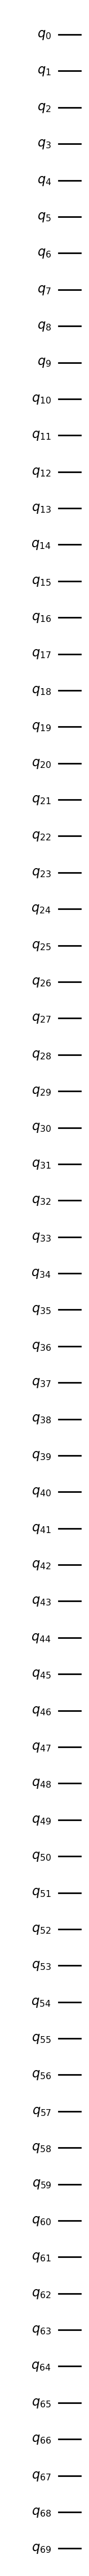

In [13]:
# Initiate the (quantum)circuit
initial_circuit2 = QuantumCircuit(n_qubits2)
# Use QuantumCircuit.prepare_state() to define the initial state 
initial_circuit2.prepare_state('0000000000000000000000000000000000000000000000000000000000000000000000')
# Change reps and see the difference when you decompose the circuit
initial_circuit2.decompose(reps=1).draw("mpl")

## Activity 4

### Prepare the quantum circuit 2 (Single circuit for time evolution) for the 70-qubit problem
We here construct a circuit for a single time step using Lie–Trotter.<br>
Exactly as in the 20-qubit case, the Lie product formula (first order) is implemented in the [LieTrotter](https://docs.quantum.ibm.com/api/qiskit/qiskit.synthesis.LieTrotter) class. Again the first order formula consists of the approximation stated above:

$$
e^{H_1+H_2} \approx e^{H_1} e^{H_2}
$$

Try this yourself, building from the example of the 20-qubit case. As before, count the operations for this circuit.<br>

__Solution:__

In [14]:
# Construct the gates using PauliEvolutionGate()
single_step_evolution_gates_lt2 = PauliEvolutionGate(
    hamiltonian2, dt, synthesis=LieTrotter()
)
# Initiate the quantum circuit
single_step_evolution_lt2 = QuantumCircuit(n_qubits2)
# Append the gates defined above
single_step_evolution_lt2.append(single_step_evolution_gates_lt2, single_step_evolution_lt2.qubits)

print(
    f"""
Trotter step with Lie-Trotter
-----------------------------
Depth: {single_step_evolution_lt2.decompose(reps=3).depth()}
Gate count: {len(single_step_evolution_lt2.decompose(reps=3))}
Nonlocal gate count: {single_step_evolution_lt2.decompose(reps=3).num_nonlocal_gates()}
Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in single_step_evolution_lt2.decompose(reps=3).count_ops().items()])}
"""
)
single_step_evolution_lt2.decompose(reps=3).draw("mpl", fold=-1)


Trotter step with Lie-Trotter
-----------------------------
Depth: 208
Gate count: 277
Nonlocal gate count: 138
Gate breakdown: CX: 138, U3: 70, U1: 69



## Activity 5

### Set the operators to be measured
We define a *magnetization operator* exactly analogous to the one from the 20-qubit case: $\sum_i Z_i  / N$. Try this yourself by modifying the 20-qubit solution.

__Solution:__

In [15]:
# Define the magnetization operator in SparsePauliOp
magnetization2= SparsePauliOp.from_sparse_list(
    [("Z", [i], 1.0) for i in range(0, n_qubits2)], num_qubits=n_qubits2
) / n_qubits2
print('magnetization : ', magnetization2)

magnetization :  SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIII', 'IIIII

# MPS simulation

## Activity 6

### Perform time-evolution simulation
We will monitor the magnetization (expectation value of the magnetization operator). We will use the MPS simulator to get the reference value to compare the results computed from the hardware. You have used the MPS simulator before in this tutorial. Modify that example where necessary to fit this new calculation.<br>

__Solution:__

In [16]:
# Step 1. Map the problem
# Initiate the circuit
evolved_state2 = QuantumCircuit(initial_circuit2.num_qubits)
# Start from the initial spin configuration
evolved_state2.append(initial_circuit2, evolved_state2.qubits)
# Define backend (MPs simulator)
backend_mps2 = AerSimulator(method='matrix_product_state')
# Initiate Runtime Estimator
estimator_mps2 = Estimator(mode=backend_mps2)
# Step 2. Optimize
# Initiate pass manager
pm_mps2 = generate_preset_pass_manager(optimization_level=3, backend=backend_mps2)
# Transpile
evolved_state_mps2 = pm_mps2.run(evolved_state2)
# Apply qubit layout to the observable to measure
magnetization_mps2 = magnetization2.apply_layout(evolved_state_mps2.layout)
# Initiate list
mag_mps_list2 = []
# Step 3. Run the circuit
# Estimate expectation values for t=0.0
job = estimator_mps2.run([(evolved_state_mps2, [magnetization_mps2])])
# Get estimated expectation values
evs = job.result()[0].data.evs
# Append to list
mag_mps_list2.append(evs[0])

# Start time evolution
for n in range(num_timesteps):
    # Step 1. Map the problem
    # Expand the circuit to describe delta-t
    evolved_state2.append(single_step_evolution_lt2, evolved_state2.qubits)
    # Step 2. Optimize
    # Transpile the circuit
    evolved_state_mps2 = pm_mps2.run(evolved_state2)
    # Apply the physical layout of the qubits to the operator
    magnetization_mps2 = magnetization2.apply_layout(evolved_state_mps2.layout)
    # Step 3. Run the circuit
    # Estimate expectation values at delta-t
    job = estimator_mps2.run([(evolved_state_mps2, [magnetization_mps2])])
    # Get estimated expectation values
    evs = job.result()[0].data.evs
    # Append to list
    mag_mps_list2.append(evs[0])
# Transform the list of expectation values (at each time step) to arrays
mag_mps_array2 = np.array(mag_mps_list2)

# Solution using a real quantum computer

As in all previous lessons, we will implement the Qiskit patterns framework. The lesson up to this point has been focused on creating the correct quantum circuits to describe our problem. This is effectively Step 1.

### Step 2: Optimize for target hardware

We start by defining the target backend.

In [16]:
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_sherbrooke'

We transpile the circuits and gather them in a list. This may take a few minutes.

In [17]:
pm_hw = generate_preset_pass_manager(optimization_level=3, backend=backend)
circuit_isa = []
# Step 1. Map the problem
evolved_state_hw = QuantumCircuit(initial_circuit2.num_qubits)
evolved_state_hw.append(initial_circuit2, evolved_state_hw.qubits)
# Step 2. Optimize
circuit_isa.append(pm_hw.run(evolved_state_hw))

for n in range(num_timesteps):
    # Step 1. Map the problem
    evolved_state_hw.append(single_step_evolution_lt2, evolved_state_hw.qubits)
    # Step 2. Optimize
    circuit_isa.append(pm_hw.run(evolved_state_hw))

### Step 3: Execute on target hardware

We will define the Runtime Estimator and construct the list of PUBs. We must also apply the layout to the operators to be measured.

In [18]:
# Step 2. Optimize
estimator_hw = Estimator(mode=backend)
pub_list=[]
for circuit in circuit_isa:
    temp = (circuit, magnetization2.apply_layout(circuit.layout))
    pub_list.append(temp)

We are now ready to run the job.

In [19]:
job = estimator_hw.run(pub_list)
print(job.job_id())

cvv5jch7cb40008e5bw0


### Step 4: Post-process results

We will first get the results.

In [20]:
pub_result = job.result()

Now we must extract the expectation values from these results.

In [21]:
mag_hw_list = []
for res in pub_result:
    evs = res.data.evs
    mag_hw_list.append(evs)

We will use this for comparison below. First, let us see if we can optimize our circuits even further.

## Solution using a real quantum computer II
Let us return to Qiskit patterns step 1, and see if we can reduce the depth of our circuit.


###  Step 1. Map the problem to quantum circuits and operators

## Activity 7

Construct a time-evolution circuit. Use your knowledge from previous lessons to try to reduce the depth of the circuit.

__Solution:__


Trotter step with Lie-Trotter
-----------------------------
Depth: 7
Gate count: 277
Nonlocal gate count: 138
Gate breakdown: CX: 138, U3: 70, U1: 69



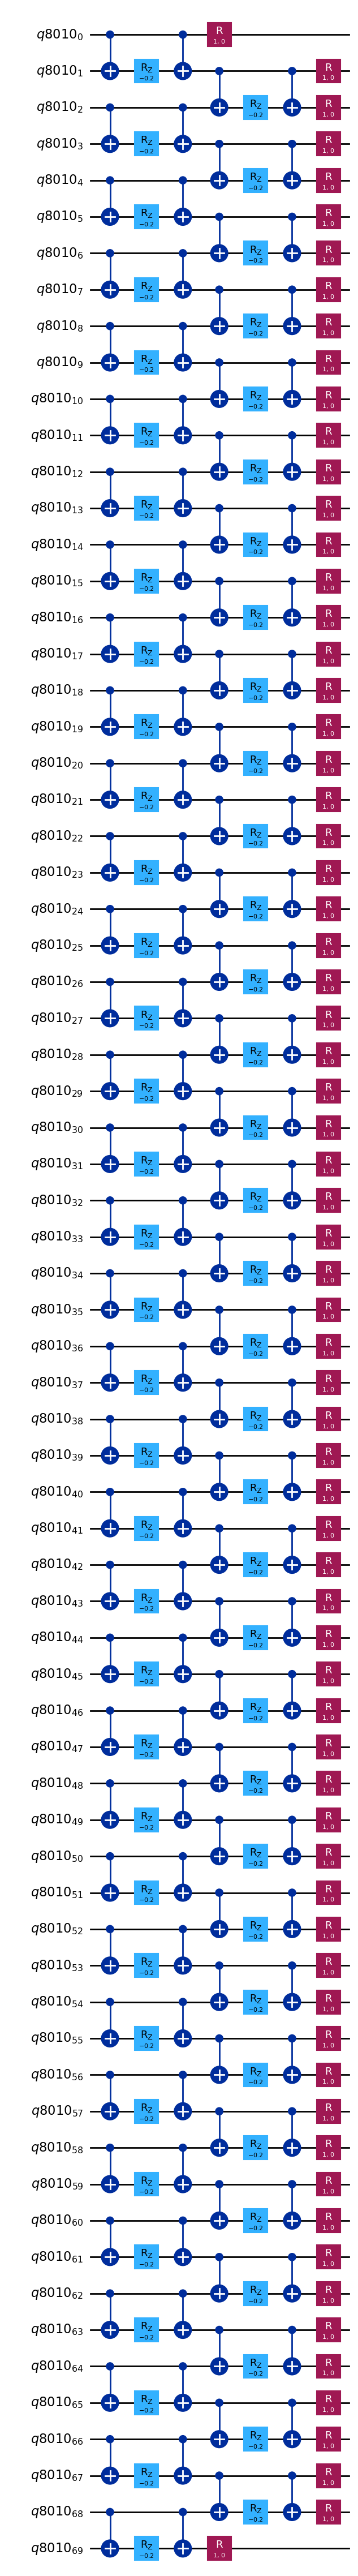

In [22]:
# Define J
J=1.0
# Define h
h=-5.0
# Create instruction for rotation around ZZ:
# Initiate the circuit (use 2 qubits)
Rzz_circ = QuantumCircuit(2)
# Add Rzz gate (do not forget to multiply the angle by 2.0)
Rzz_circ.rzz(-J*dt*2.0, 0, 1)
# Transform the QuantumCircuit to instruction (QuantumCircuit.to_instruction())
Rzz_instr = Rzz_circ.to_instruction(label="RZZ")

# Create instruction for rotation around X:
# Initiate the circuit (use 1 qubit)
Rx_circ = QuantumCircuit(1)
# Add Rx gate (do not forget to multiply the angle by 2.0)
Rx_circ.rx(-h*dt*2.0, 0)
# Transform the QuantumCircuit to instruction (QuantumCircuit.to_instruction())
Rx_instr = Rx_circ.to_instruction(label="RX")

# Define the interaction list
interaction_list = [
    [[i, i + 1] for i in range(0, n_qubits2 - 1, 2)],
    [[i, i + 1] for i in range(1, n_qubits2 - 1, 2)],
]  # linear chain

# Define the registers
qr = QuantumRegister(n_qubits2)
# Initiate the circuit
single_step_evolution_sh = QuantumCircuit(qr)
# Construct the Rzz gates
for i, color in enumerate(interaction_list):
    for interaction in color:
        single_step_evolution_sh.append(Rzz_instr, interaction)

# Construct the Rx gates
for i in range(0, n_qubits2):
    single_step_evolution_sh.append(Rx_instr, [i])

print(
    f"""
Trotter step with Lie-Trotter
-----------------------------
Depth: {single_step_evolution_sh.decompose(reps=3).depth()}
Gate count: {len(single_step_evolution_sh.decompose(reps=3))}
Nonlocal gate count: {single_step_evolution_sh.decompose(reps=3).num_nonlocal_gates()}
Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in single_step_evolution_sh.decompose(reps=3).count_ops().items()])}
"""
)

single_step_evolution_sh.decompose(reps=2).draw("mpl")

This was very successful. We can now proceed with the remaining Qiskit patterns steps.

###  Step 2. Optimize for target hardware

Transpile the circuits and gather them in a list. Once again, this may take a few minutes.

In [23]:
pm_hw2 = generate_preset_pass_manager(backend=backend, optimization_level=3)
circuit_isa2 = []
# Step 1. Map the problem
evolved_state_hw2 = QuantumCircuit(initial_circuit2.num_qubits)
evolved_state_hw2.append(initial_circuit2, evolved_state_hw2.qubits)
# Step 2. Optimize
circuit_isa2.append(pm_hw2.run(evolved_state_hw2))
for n in range(num_timesteps):
    # Step 1. Map the problem
    evolved_state_hw2.append(single_step_evolution_sh, evolved_state_hw2.qubits)
    # Step 2. Optimize
    circuit_isa2.append(pm_hw2.run(evolved_state_hw2))

Define the Runtime Estimator and construct the list of PUBs.

In [24]:
estimator_hw2 = Estimator(mode=backend)
pub_list2=[]
for circuit in circuit_isa2:
    temp = (circuit, magnetization2.apply_layout(circuit.layout))
    pub_list2.append(temp)

### Step 3. Execute on target hardware
Run the job.

In [25]:
job2 = estimator_hw2.run(pub_list2)
print(job2.job_id())

cvv5nny5sat0008hwtag


Get the results.

In [26]:
pub_result2 = job2.result()

### Step 4. Postprocessing
Extract the expectation values from the results.

In [27]:
mag_hw_list2 = []
for res in pub_result2:
    evs = res.data.evs
    mag_hw_list2.append(evs)

Transform the list into numpy arrays for plotting.

In [28]:
mag_hw_array = np.array(mag_hw_list)
mag_hw_array2 = np.array(mag_hw_list2)

Now let us plot the results and compare the hardware (default and shallow circuit) results with the MPS simulator. How does the error in the real hardware influence the results?

Text(0.5, 0.98, 'Observable evolution')

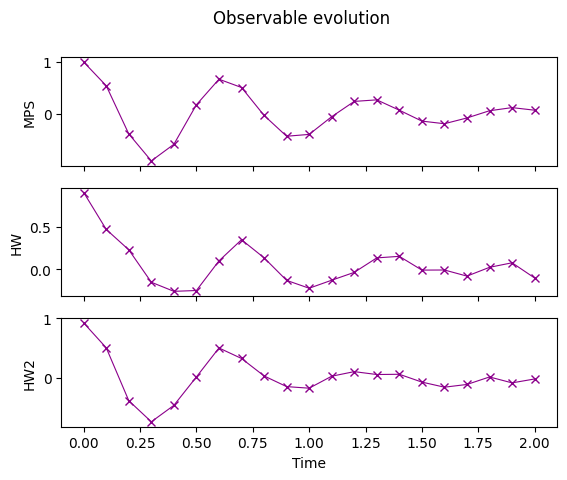

In [29]:
fig, axes = plt.subplots(3, sharex=True)
times = np.linspace(0, evolution_time, num_timesteps + 1)  # includes initial state
axes[0].plot(
    times, mag_mps_array2, label="MPS", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[1].plot(
    times, mag_hw_array , label="HW", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[2].plot(
    times, mag_hw_array2 , label="HW2", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[0].set_ylabel("MPS")
axes[1].set_ylabel("HW")
axes[2].set_ylabel("HW2")
axes[2].set_xlabel("Time")
fig.suptitle("Observable evolution")

Congratulations! You have moved one step further in your utility-scale quantum journey. There is only one lesson left!